# Inception CNN Demo - 32 Classes

### We will test the Inception CNN on a random batch of 150 doodles and see which are correctly/incorrectly classified.

In [1]:
import os, sys
import importlib
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils import load_torch, load

### Load the sample batch

#### The data is on the server. Use the command 'ln -s /datasets/ee285f-public/quickdraw' after launching your pod. This will load the dataset. 

In [15]:
importlib.reload(load_torch)

data_folder = "quickdraw/train_simplified/"
access_file_generator = map(lambda x : data_folder + x + '.csv', load.classes)
generate = load_torch.ImageLoader(classes=load.classes_1+load.classes_2+load.classes_3+load.classes_4,root_location=data_folder,read_size=32,batch_size=150)
gen = generate.__iter__()

In [16]:
%matplotlib inline
X, y = next(gen)
print('X.shape:', X.shape)
print('y.shape:', y.shape)

X.shape: torch.Size([150, 1, 32, 32])
y.shape: torch.Size([150])


### Define Inception CNN Architecture

In [4]:
# Code derived from: https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as ag
import torch.optim as optim

class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

class InceptionModule(nn.Module):

    def __init__(self, in_channels):
        super(InceptionModule, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 12, kernel_size=1)

        self.branch3x3_1 = BasicConv2d(in_channels, 24, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(24, 24, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = BasicConv2d(24, 24, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 32, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(32, 24, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = BasicConv2d(24, 24, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = BasicConv2d(24, 24, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = BasicConv2d(in_channels, 16, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)
    
class DoodleInception(nn.Module):
    # Here we define our network structure
    name="doodle-inception"
    def __init__(self, cdim=8):
        super(DoodleInception, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3).double() 
        self.mod1  = InceptionModule(6).double()
        self.conv2 = nn.Conv2d(124, 128, 3).double()
        self.fc1   = nn.Linear(512,128).double()
        self.fc2   = nn.Linear(128,cdim).double()
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.mod1(x)), (2, 2))  #?x124x7x7
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))  #?x128x2x2
        x = x.view(-1, int(self.num_flat_features(x)))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    # Determine the number of features in a batch of tensors
    def num_flat_features(self, x): 
        size = x.size()
        return np.prod(size[1:])

### Load the pre-trained network

In [5]:
classes = load.classes_1+load.classes_2+load.classes_3+load.classes_4
net = DoodleInception(cdim=len(classes))
net.load_state_dict(torch.load("utils/inception_cnn_32.pt"))
net.eval()
print(net)

DoodleInception(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (mod1): InceptionModule(
    (branch1x1): BasicConv2d(
      (conv): Conv2d(6, 12, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(12, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch3x3_1): BasicConv2d(
      (conv): Conv2d(6, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch3x3_2a): BasicConv2d(
      (conv): Conv2d(24, 24, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
      (bn): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch3x3_2b): BasicConv2d(
      (conv): Conv2d(24, 24, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
      (bn): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch3x3dbl_1): BasicConv2d(
      (c

### Evaluate the batch, possible lables are shown

In [17]:
ypred = net(X)
print(classes)

['airplane', 'angel', 'basket', 'bear', 'belt', 'candle', 'crown', 'cat', 'bee', 'crab', 'drums', 'elephant', 'hospital', 'mouse', 'onion', 'tree', 'book', 'camel', 'camera', 'carrot', 'matches', 'microwave', 'nose', 'toaster', 'apple', 'cloud', 'dresser', 'drill', 'mug', 'pool', 'submarine', 'toilet']


### Check for incorrect labels

In [18]:
correct_label = []
incorrect_label = []
doodle = []

for i in range(150):
    if ypred[i].data.numpy().T.argmax(axis =0) != y[i]:
        incorrect_label.append(ypred[i].data.numpy().T.argmax(axis =0))
        correct_label.append(y[i])
        doodle.append(X[i])
        
num_incorrect = len(incorrect_label)
print("Out of 150, there are %s incorrectly classified samples" %num_incorrect)

Out of 150, there are 20 incorrectly classified samples


Here are 5 incorrectly classified examples:


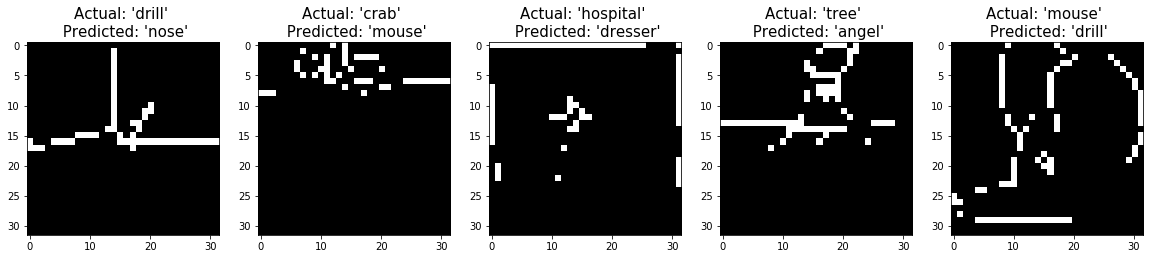

In [19]:
print("Here are 5 incorrectly classified examples:")
plt.figure(figsize = (20,20))
for i in range(5):
    actual_label = classes[correct_label[i]]
    predicted_label = classes[incorrect_label[i]]
    plt.subplot(1,5,i+1)
    img =1-doodle[i][0].numpy()
    #img = img.resize((50,50))
    plt.imshow(img, cmap='gray')
    plt.title("Actual: '{0}' \n Predicted: '{1}'".format(actual_label,predicted_label) , fontsize = 15 )



### Check for correct labels

In [20]:
correct_label = []
doodle = []

for i in range(150):
    if ypred[i].data.numpy().T.argmax(axis =0) == y[i]:
        correct_label.append(y[i])
        doodle.append(X[i])

num_correct = len(correct_label)
print("Out of 150, there are %s correctly classified samples" %num_correct)

Out of 150, there are 130 correctly classified samples


Here are 5 correctly classified exmaples:


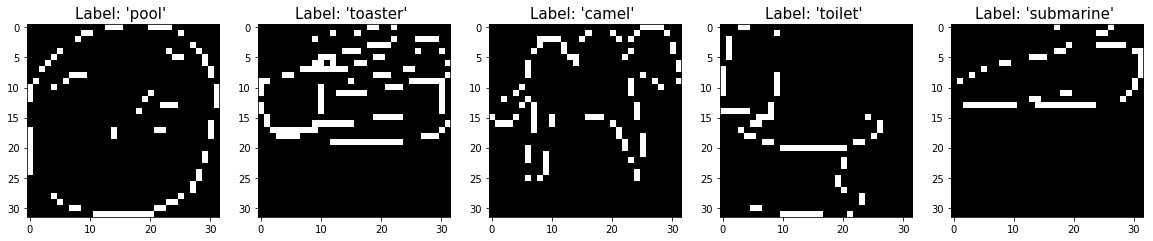

In [21]:
print("Here are 5 correctly classified exmaples:")

plt.figure(figsize = (20,20))
for i in range(5):
    actual_label = classes[correct_label[i]]
    plt.subplot(1,5,i+1)
    img =1-doodle[i][0].numpy()
    plt.imshow(img, cmap='gray')
    plt.title("Label: '{0}' ".format(actual_label) , fontsize = 15 )

